###1.Data Loading


In [ ]:
!pip install -q kaggle

from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"khueluong","key":"fa07b2a99eed1f69c6833a094a309ef6"}'}

In [ ]:
!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d alxmamaev/flowers-recognition

 97% 217M/225M [00:03<00:00, 70.3MB/s]
100% 225M/225M [00:03<00:00, 72.9MB/s]


In [ ]:
!unzip -q flowers-recognition.zip

In [ ]:
import numpy as np
import pandas as pd

import os
import random
from operator import itemgetter
import copy
import time
import cv2
import torch
import torchvision
import torchvision.transforms as transform
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import torch.nn as nn
import torchvision.models as models
from torchvision.utils import make_grid
import torch.nn.functional as F

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
import seaborn as sns

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
example = '/content/flowers/rose'
path = '/content/flowers'

Shape: (240, 320, 3)


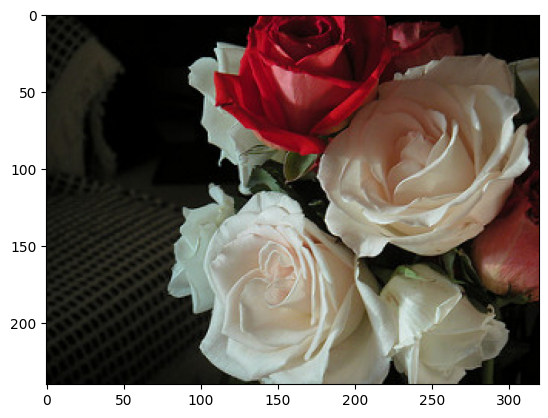

In [ ]:
img = mpimg.imread(example + '/102501987_3cdb8e5394_n.jpg')
print('Shape:', img.shape)
plt.imshow(img);

In [ ]:
def plotHist(img):
  plt.figure(figsize=(15,5))
  plt.subplot(1,2,1)
  plt.imshow(img, cmap='gray')
  plt.axis('off')
  histo = plt.subplot(1,2,2)
  histo.set_ylabel('Count')
  histo.set_xlabel('Pixel Intensity')
  plt.hist(img.flatten(), bins=10, lw=0, color='b', alpha=0.5)

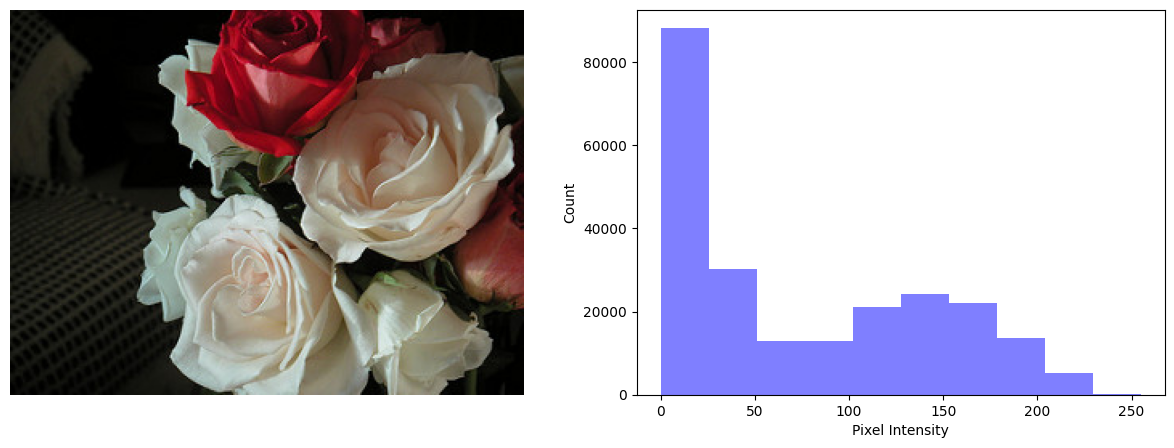

In [ ]:
 plotHist(img)

- Histogram của bức ảnh cho thấy dữ liệu chưa được chuẩn hóa. Do đó, việc đầu tiên cần làm là chuẩn hóa dữ liệu.


### 2. Data preparation

In [ ]:
transformer = {
    'original': transform.Compose([
                                 transform.Resize((220, 220)),
                                 transform.ToTensor(),
                                 transform.Normalize((0.4124234616756439, 0.3674212694168091, 0.2578217089176178),
                                                     (0.3268945515155792, 0.29282665252685547, 0.29053378105163574))
]),
     }

- Hàm transform.Resize((220, 220)): Thay đổi kích thước của hình ảnh về kích thước mới là (220, 220) để đảm bảo rằng tất cả các hình ảnh đều có cùng kích thước để phù hợp với mô hình và để giảm độ phức tạp tính toán.
- Hàm transform.ToTensor(): Chuyển đổi hình ảnh từ định dạng hình ảnh sang định dạng tensor.
- transform.Normalize(mean, std): Thực hiện phép chuẩn hóa trên tensor hình ảnh. Cụ thể, nó trừ đi giá trị trung bình (mean) và chia cho độ lệch chuẩn (std). Trong trường hợp này, mean và std được cung cấp là giá trị trung bình và độ lệch chuẩn của các thành phần màu (R, G, B) của ảnh.
- Ý nghĩa của việc này là để giúp đảm bảo rằng dữ liệu đầu vào cho mô hình có thể được xử lý hiệu quả và giảm thiểu sự biến động trong dữ liệu.


In [ ]:
bs = 50
original = ImageFolder(path, transform=transformer['original'])

train_val, test = train_test_split(original, test_size=0.2, shuffle=True, random_state=43)
train, val = train_test_split(train_val, test_size=0.2, shuffle=True, random_state=43)

loaders = {
    'train': DataLoader(train, batch_size=bs, num_workers=4, pin_memory=True),
    'val': DataLoader(val, batch_size=bs, num_workers=4, pin_memory=True),
    'test': DataLoader(test, batch_size=bs, num_workers=4, pin_memory=True)
}

dataset_sizes = {
    'train': len(train),
    'val': len(val),
    'test': len(test),
}


- Chọn kích thước batch (số lượng mẫu dữ liệu được sử dụng trong mỗi lần cập nhật trọng số của mô hình) là 50.
- Chia dữ liệu thành 2 tập train_val và test lần lượt có kích thước lần lượt là 80% và 20% của bộ dữ liệu.
- Tiếp tục chia tập train_val thành 2 tập train và tập tập validation (val) có kích thước lần lượt bằng 80% và 20% của tập train_val.
- Tạo các đối tượng DataLoader để hiệu quả hóa việc đọc dữ liệu trong quá trình đào tạo mô hình. num_workers là số lượng tiến trình sẽ được sử dụng để đọc dữ liệu đồng thời và pin_memory làm cho việc chuyển dữ liệu từ bộ nhớ chính sang bộ nhớ GPU được thực hiện nhanh chóng hơn.

####2.1 Kiểm tra việc chuẩn hóa dữ liệu


In [ ]:
channels = 3

for channel in range(channels):
    for x in ['train', 'val', 'test']:
        num_pxl = dataset_sizes[x]*220*220

        #chia tổng cho số lượng tất cả các pixel để tính giá trị trung bình
        total_sum = 0
        for batch in loaders[x]:
            layer = list(map(itemgetter(channel), batch[0]))
            layer = torch.stack(layer, dim=0)
            total_sum += layer.sum()
        mean = total_sum / num_pxl

        #Tính độ lệch chuẩn
        sum_sqrt = 0
        for batch in loaders[x]:
            layer = list(map(itemgetter(channel), batch[0]))
            sum_sqrt += ((torch.stack(layer, dim=0) - mean).pow(2)).sum()
        std = torch.sqrt(sum_sqrt / num_pxl)

        print(f'|channel:{channel+1}| {x}  mean: {mean}, std: {std}')

|channel:1| train  mean: 0.15366697311401367, std: 0.9009557366371155
|channel:1| val  mean: 0.1350022256374359, std: 0.8978251218795776
|channel:1| test  mean: 0.11246328055858612, std: 0.8949926495552063
|channel:2| train  mean: 0.18441209197044373, std: 0.9041170477867126
|channel:2| val  mean: 0.17878468334674835, std: 0.9013481736183167
|channel:2| test  mean: 0.1657453328371048, std: 0.8847270011901855
|channel:3| train  mean: 0.15261772274971008, std: 0.9925718903541565
|channel:3| val  mean: 0.13436952233314514, std: 0.9773147702217102
|channel:3| test  mean: 0.13841129839420319, std: 0.9690633416175842


- Kiểm tra việc chuẩn hóa dữ liệu ở từng kênh màu trên tập train, test và val, ta thấy giá trị trung bình gần 0 và độ lệch chuẩn gần 1 cho thấy các bức ảnh trong tập train và tập val đã được chuẩn hóa ở cả ba kênh màu.

####2.2 Kiểm tra số lượng class và số lượng mẫu của mỗi class



In [ ]:
print('Classes:', original.classes)
print('Number of classes:', len(original.classes))

Classes: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Number of classes: 5


In [ ]:
dic = {}

for classes in original.classes:
  dic[classes] = [len([os.path.join(path+'/'+classes, filename) for filename in os.listdir(path+'/'+classes)])]

samplesize = pd.DataFrame.from_dict(dic)

In [ ]:
samplesize

,daisy,dandelion,rose,sunflower,tulip
0,764,1052,784,733,984


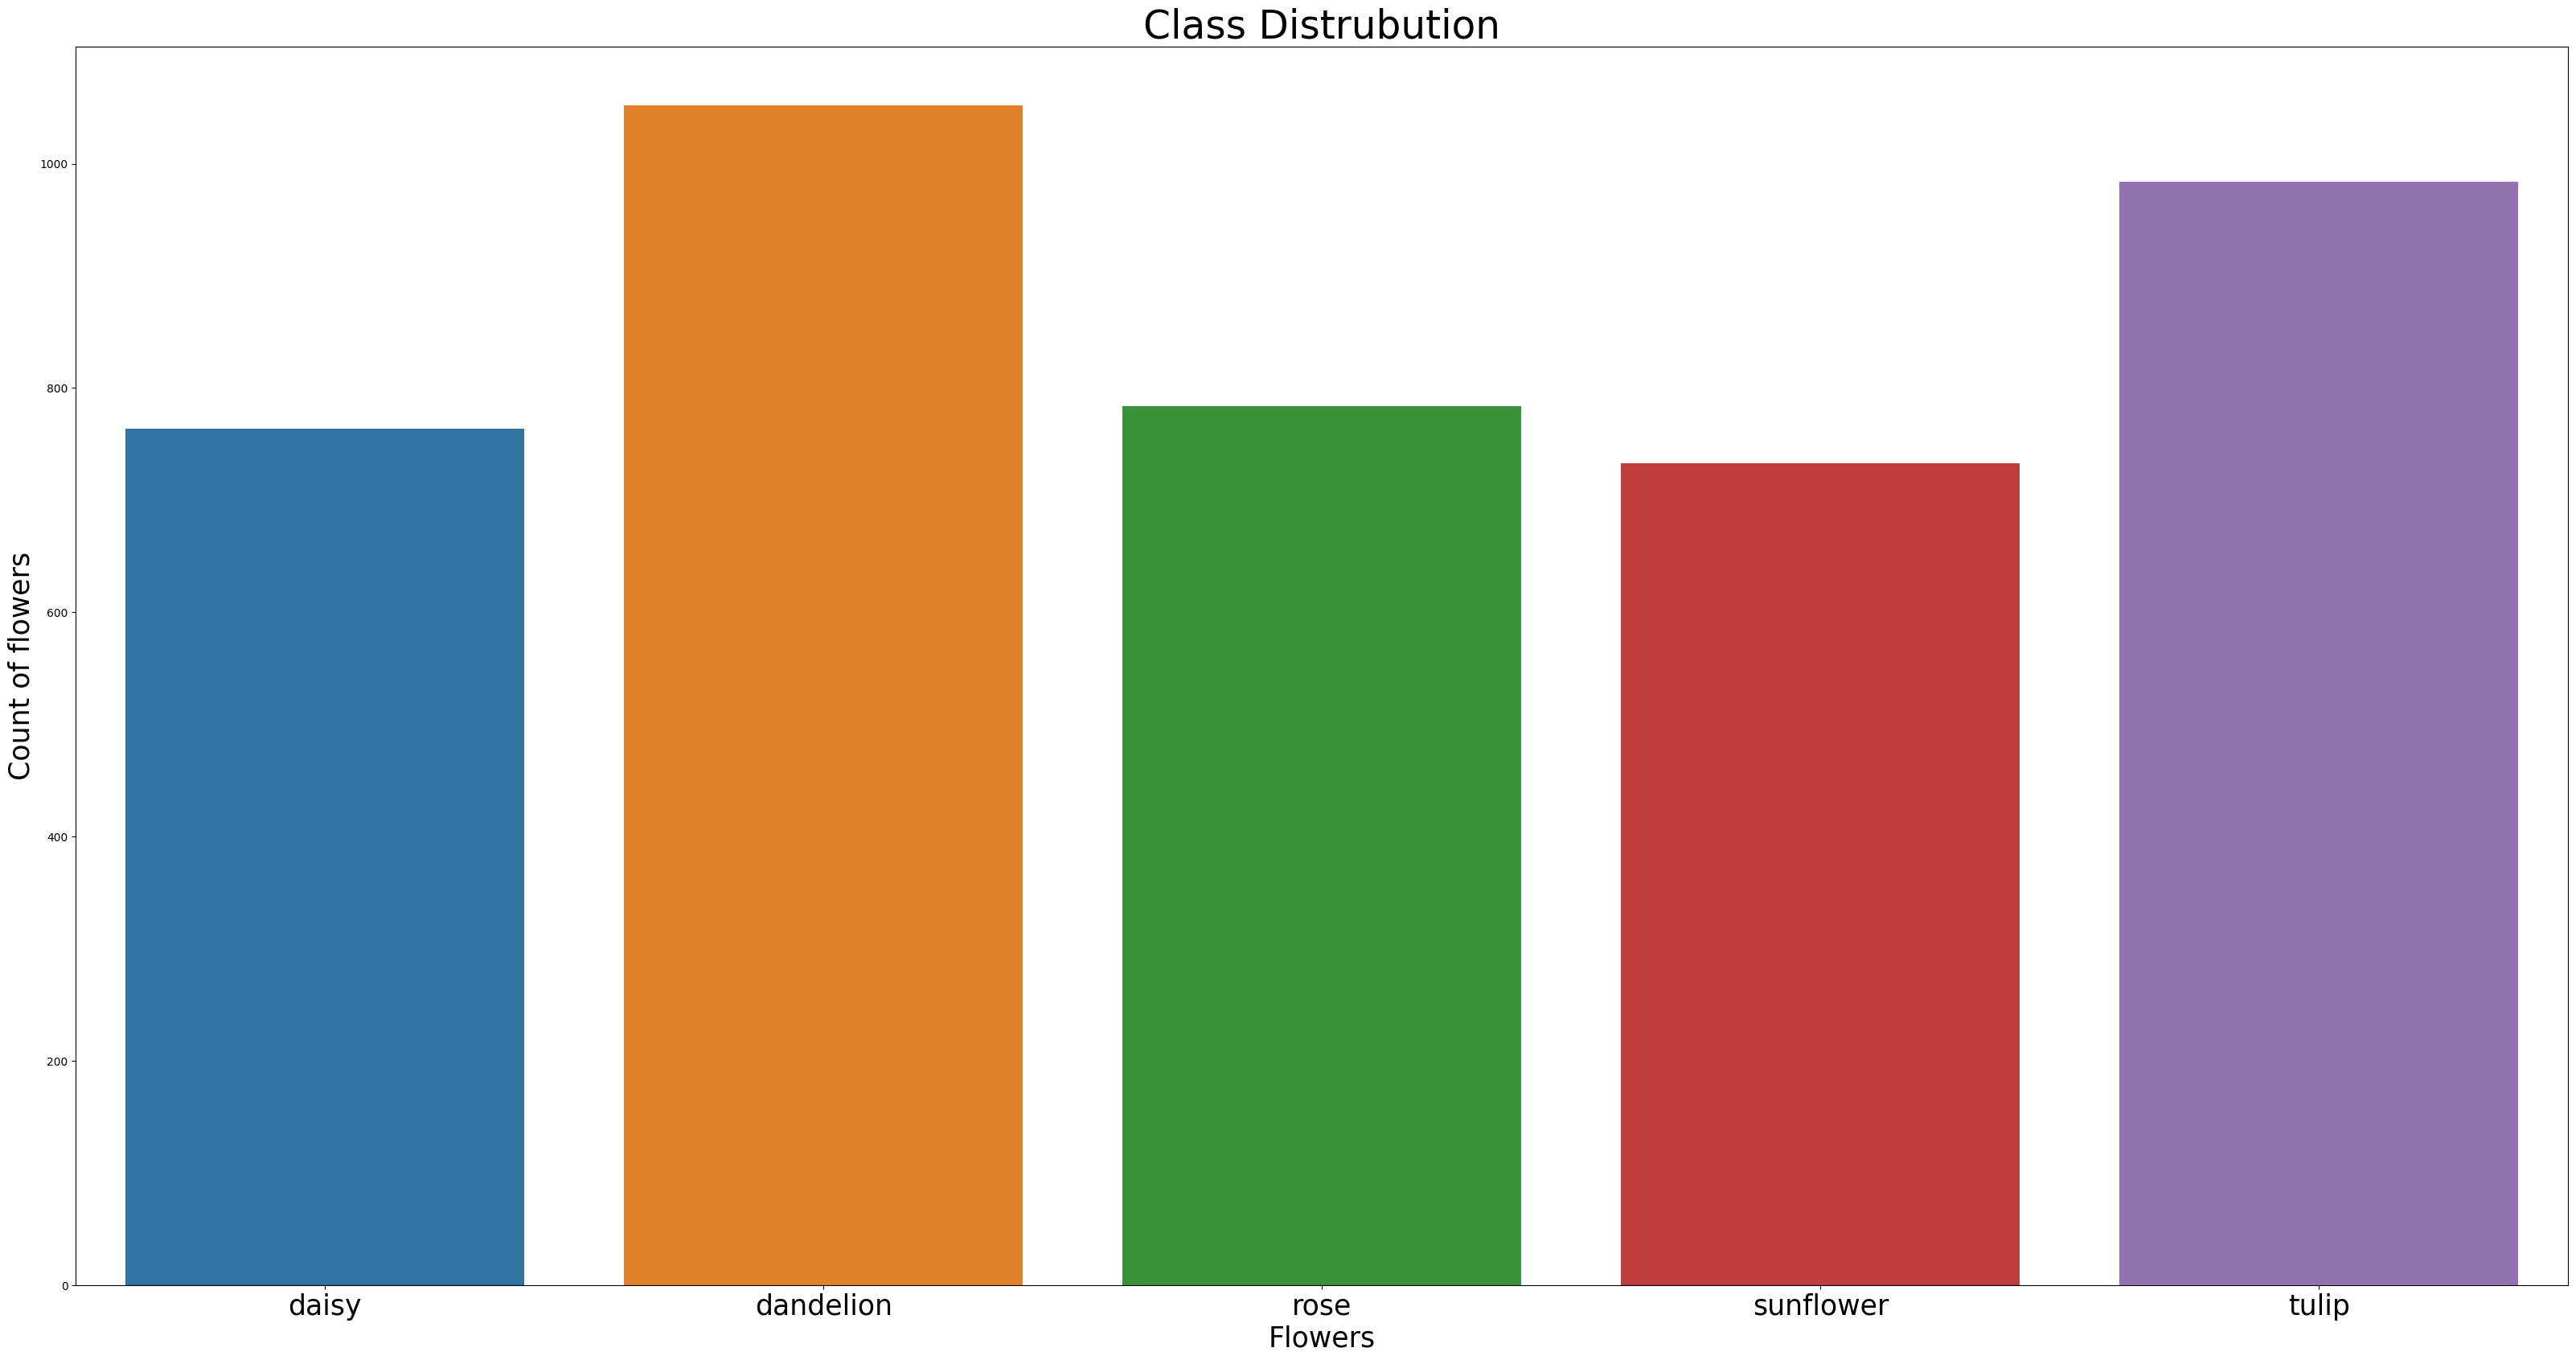

In [ ]:
figure_size = plt.rcParams['figure.figsize']
figure_size[0] = 40
figure_size[1] = 20
plt.rcParams['figure.figsize'] = figure_size

sns.barplot(data=samplesize)

index = np.arange(len(original.classes))

plt.xlabel('Flowers', fontsize=25)
plt.ylabel('Count of flowers', fontsize=25)
plt.xticks(index, original.classes, fontsize=25)
plt.title('Class Distrubution', fontsize=35)
plt.show()

- Từ biểu đồ có thể thấy được lớp dandelion có số lượng mẫu nhiều nhất.
- Lớp tulip có số lượng mẫu xếp thứ hai.
- Hai lớp daisy và rose có số lượng mẫu trung bình xấp xỉ nhau.
- Lớp sunflower có số lượng mẫu thấp nhất.
- Tỉ lệ giữa lớp nhất và lớp nhỏ nhất là 1052/733 = 1.44. Do 1.44 là khá nhỏ nên bộ dữ liệu không gặp hiện tượng mất cân bằng( lớp đa số có khá nhiều mẫu trong khi lớp thiểu số có quá ít mẫu dẫn đến mô hình học quá nhiều ở các lớp đa số nhưng lại quá ít ở các lớp thiểu số.)

#### 2.3 Đối chiếu dữ liệu gốc và dữ liệu đã qua biến đổi

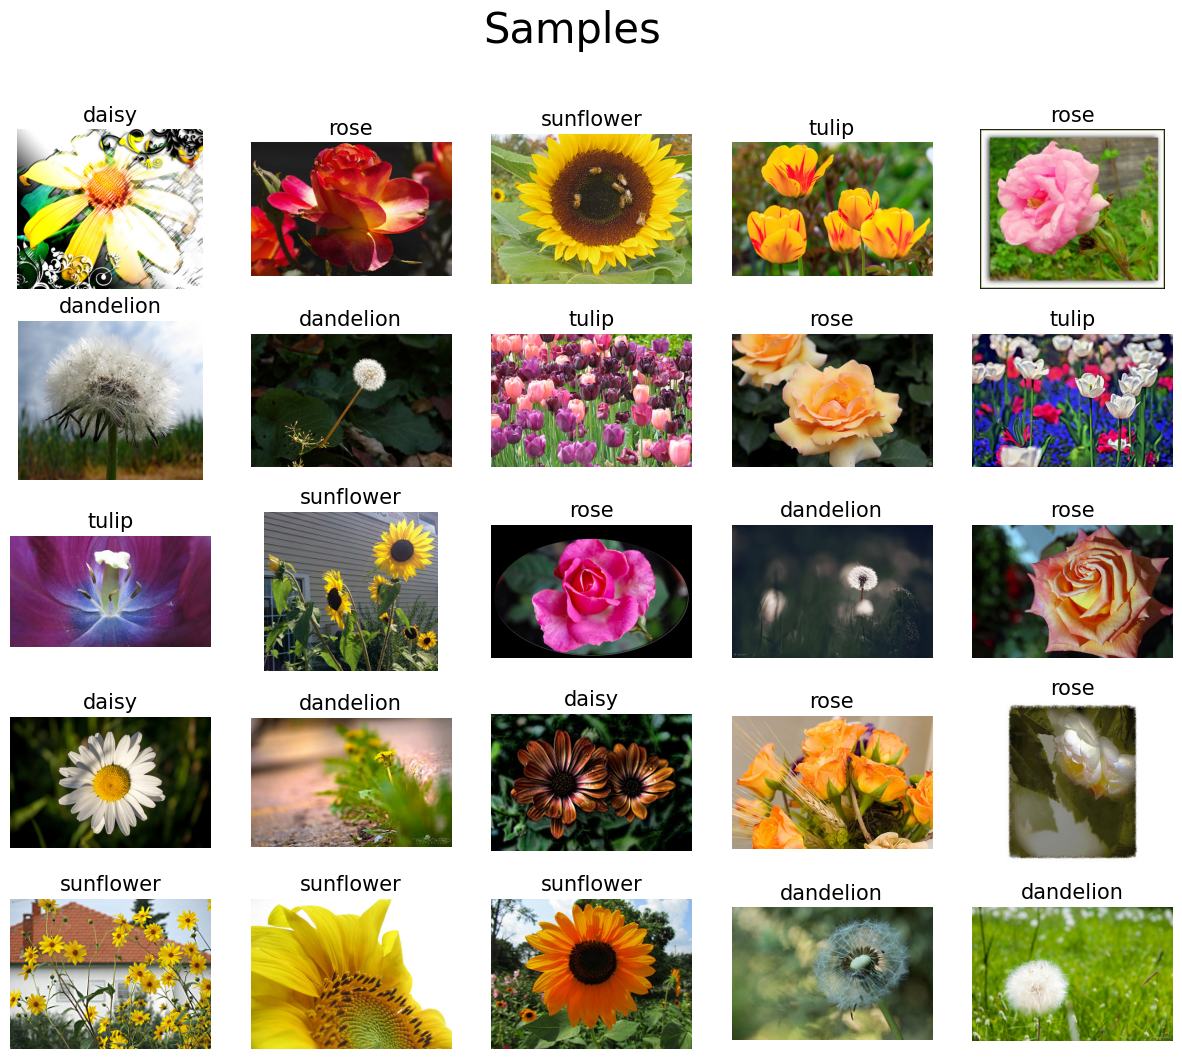

In [ ]:
def plot_samples(samples):
    fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(15,12))
    i = 0
    for row in range(5):
         for col in range(5):
                img = mpimg.imread(samples[i][0][0])
                ax[row][col].imshow(img)
                ax[row][col].axis('off')
                ax[row][col].set_title(samples[i][1], fontsize=15)
                i+=1


rand_samples = []
for _ in range(25):
    classes = random.choice(original.classes)
    rand_samples.append([random.sample([os.path.join(path+'/'+classes, filename) for filename in os.listdir(path+'/'+classes)], 1), classes])
rand_samples[0]
plot_samples(rand_samples)
plt.suptitle('Samples', fontsize=30)
plt.show()

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(25, 25))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:60], nrow=10).permute(1, 2, 0))
        ax.set_title('Images with augmentation', fontsize=40)
        break

show_batch(loaders['train'])

Output hidden; open in https://colab.research.google.com to view.

### 3. Train model
- Dùng pre-trained models.
- Huấn luyện trong 10 epochs
- Từ kết quả tốt nhất của tập val, chọn ra bộ tham số tốt nhất
- Sau đó huấn luyện thêm 10 epochs nữa.

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

In [ ]:

losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}
lr = []

In [ ]:
def train(seed, epochs, model):

  print('Creating a model {}...'.format(seed))

  model.to(device)
  criterion = nn.CrossEntropyLoss()# Xác định hàm mất mát, trong trường hợp này là hàm mất mát CrossEntropy, được sử dụng cho bài toán phân loại nhiều lớp.
  if seed==1 or seed==2:
    #Tạo một bộ tối ưu Adam để tối ưu hóa trọng số của mô hình.
    optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay = 1e-5)
  else:
    optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)# Lưu thời điểm bắt đầu
  since = time.time()
  # Khởi tạo biến để theo dõi trạng thái tốt nhất của mô hình và độ chính xác tốt nhất trên tập validation.
  best_model = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  for epoch in range(epochs):
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      running_corrects = 0.0

      for inputs, labels in loaders[phase]:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.set_grad_enabled(phase=='train'):
          outp = model(inputs)
          _, pred = torch.max(outp, 1)
          loss = criterion(outp, labels)

          if phase == 'train':
            loss.backward()
            optimizer.step()
        running_loss += loss.item()*inputs.size(0)
        running_corrects += torch.sum(pred == labels.data)

      if phase == 'train':
          acc = 100. * running_corrects.double() / dataset_sizes[phase]
          scheduler.step(acc)

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double()/dataset_sizes[phase]
      losses[phase].append(epoch_loss)
      accuracies[phase].append(epoch_acc)
      if phase == 'train':
        print('Epoch: {}/{}'.format(epoch+1, epochs))
      print('{} - loss:{}, accuracy{}'.format(phase, epoch_loss, epoch_acc))
      lr.append(scheduler._last_lr)

      if phase == 'val':
        print('Time: {}m {}s'.format((time.time()- since)//60, (time.time()- since)%60))
        print('=='*31)
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model = copy.deepcopy(model.state_dict())
  time_elapsed = time.time() - since
  print('CLASSIFIER TRAINING TIME {}m {}s'.format(time_elapsed//60, time_elapsed%60))
  print('=='*31)
  model.load_state_dict(best_model)#nạp trạng thái tốt nhất của mô hình.
  for param in model.parameters():
        param.requires_grad=True
  # Tạo một bộ tối ưu Adam mới để tiếp tục đào tạo mô hình.
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=2, verbose=True)
  for epoch in range(epochs):
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      running_corrects = 0.0

      for inputs, labels in loaders[phase]:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase=='train'):
          outp = model(inputs)
          _, pred = torch.max(outp, 1)
          loss = criterion(outp, labels)

          if phase == 'train':
            loss.backward()
            optimizer.step()
        running_loss += loss.item()*inputs.size(0)
        running_corrects += torch.sum(pred == labels.data)

      if phase == 'train':
        acc = 100. * running_corrects.double() / dataset_sizes[phase]
        scheduler.step(acc)

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double()/dataset_sizes[phase]
      losses[phase].append(epoch_loss)
      accuracies[phase].append(epoch_acc)
      if phase == 'train':
        print('Epoch: {}/{}'.format(epoch+1, epochs))
      print('{} - loss:{}, accuracy{}'.format(phase, epoch_loss, epoch_acc))
      lr.append(scheduler._last_lr)

      if phase == 'val':
        print('Time: {}m {}s'.format((time.time()- since)//60, (time.time()- since)%60))
        print('=='*31)
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model = copy.deepcopy(model.state_dict())
  time_elapsed = time.time() - since
  print('ALL NET TRAINING TIME {}m {}s'.format(time_elapsed//60, time_elapsed%60))
  print('=='*31)

  model.load_state_dict(best_model)
  return model

In [ ]:
densenet121_0 = torchvision.models.densenet121(pretrained=True)
for param in densenet121_0.parameters():
  param.requires_grad=False

densenet121_0.classifier = nn.Linear(in_features=densenet121_0.classifier.in_features, out_features=len(original.classes), bias=True)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 149MB/s]


In [ ]:
googlenet = torchvision.models.googlenet(pretrained=True)
for param in googlenet.parameters():
  param.grad_requires = False

googlenet.fc = nn.Linear(in_features=googlenet.fc.in_features, out_features=len(original.classes), bias=True)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 142MB/s]


In [ ]:
resnet101 = torchvision.models.resnet101(pretrained=True)
for param in resnet101.parameters():
  param.grad_requires = False

resnet101.fc = nn.Linear(in_features=resnet101.fc.in_features, out_features=len(original.classes), bias=True)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:05<00:00, 33.6MB/s]


In [ ]:
vgg19_bn = torchvision.models.vgg19_bn(pretrained=True)
for param in vgg19_bn.parameters():
  param.grad_requires = False

vgg19_bn.classifier[6] = nn.Linear(4096, len(original.classes), bias=True)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:14<00:00, 40.1MB/s]


In [ ]:
num_models = 4
#num_models = 3
epochs = 10

models = [densenet121_0,googlenet, resnet101, vgg19_bn]
#models = [densenet121_1,densenet121_1, googlenet]

for seed in range(num_models):
   train(seed=seed, epochs=epochs, model=models[seed])

Creating a model 0...
Epoch: 1/10
train - loss:0.9194339914955495, accuracy0.6969587255611875
val - loss:0.5815548171355307, accuracy0.8350217076700434
Time: 0.0m 13.767269611358643s
Epoch: 2/10
train - loss:0.4905743779348861, accuracy0.8508327299058652
val - loss:0.4543011091897526, accuracy0.8740955137481909
Time: 0.0m 27.119549036026s
Epoch: 3/10
train - loss:0.39794583110426063, accuracy0.8823316437364228
val - loss:0.40233819533878057, accuracy0.8871201157742402
Time: 0.0m 40.50846743583679s
Epoch: 4/10
train - loss:0.34759025604806026, accuracy0.9007965242577841
val - loss:0.37429734163104883, accuracy0.8914616497829232
Time: 0.0m 54.04631853103638s
Epoch: 5/10
train - loss:0.3133558332812173, accuracy0.9105720492396814
val - loss:0.35700045713639983, accuracy0.894356005788712
Time: 1.0m 7.771438837051392s
Epoch: 6/10
train - loss:0.28769337174945947, accuracy0.9163649529326574
val - loss:0.3453091586981772, accuracy0.8929088277858176
Time: 1.0m 21.47498059272766s
Epoch: 7/10
tr

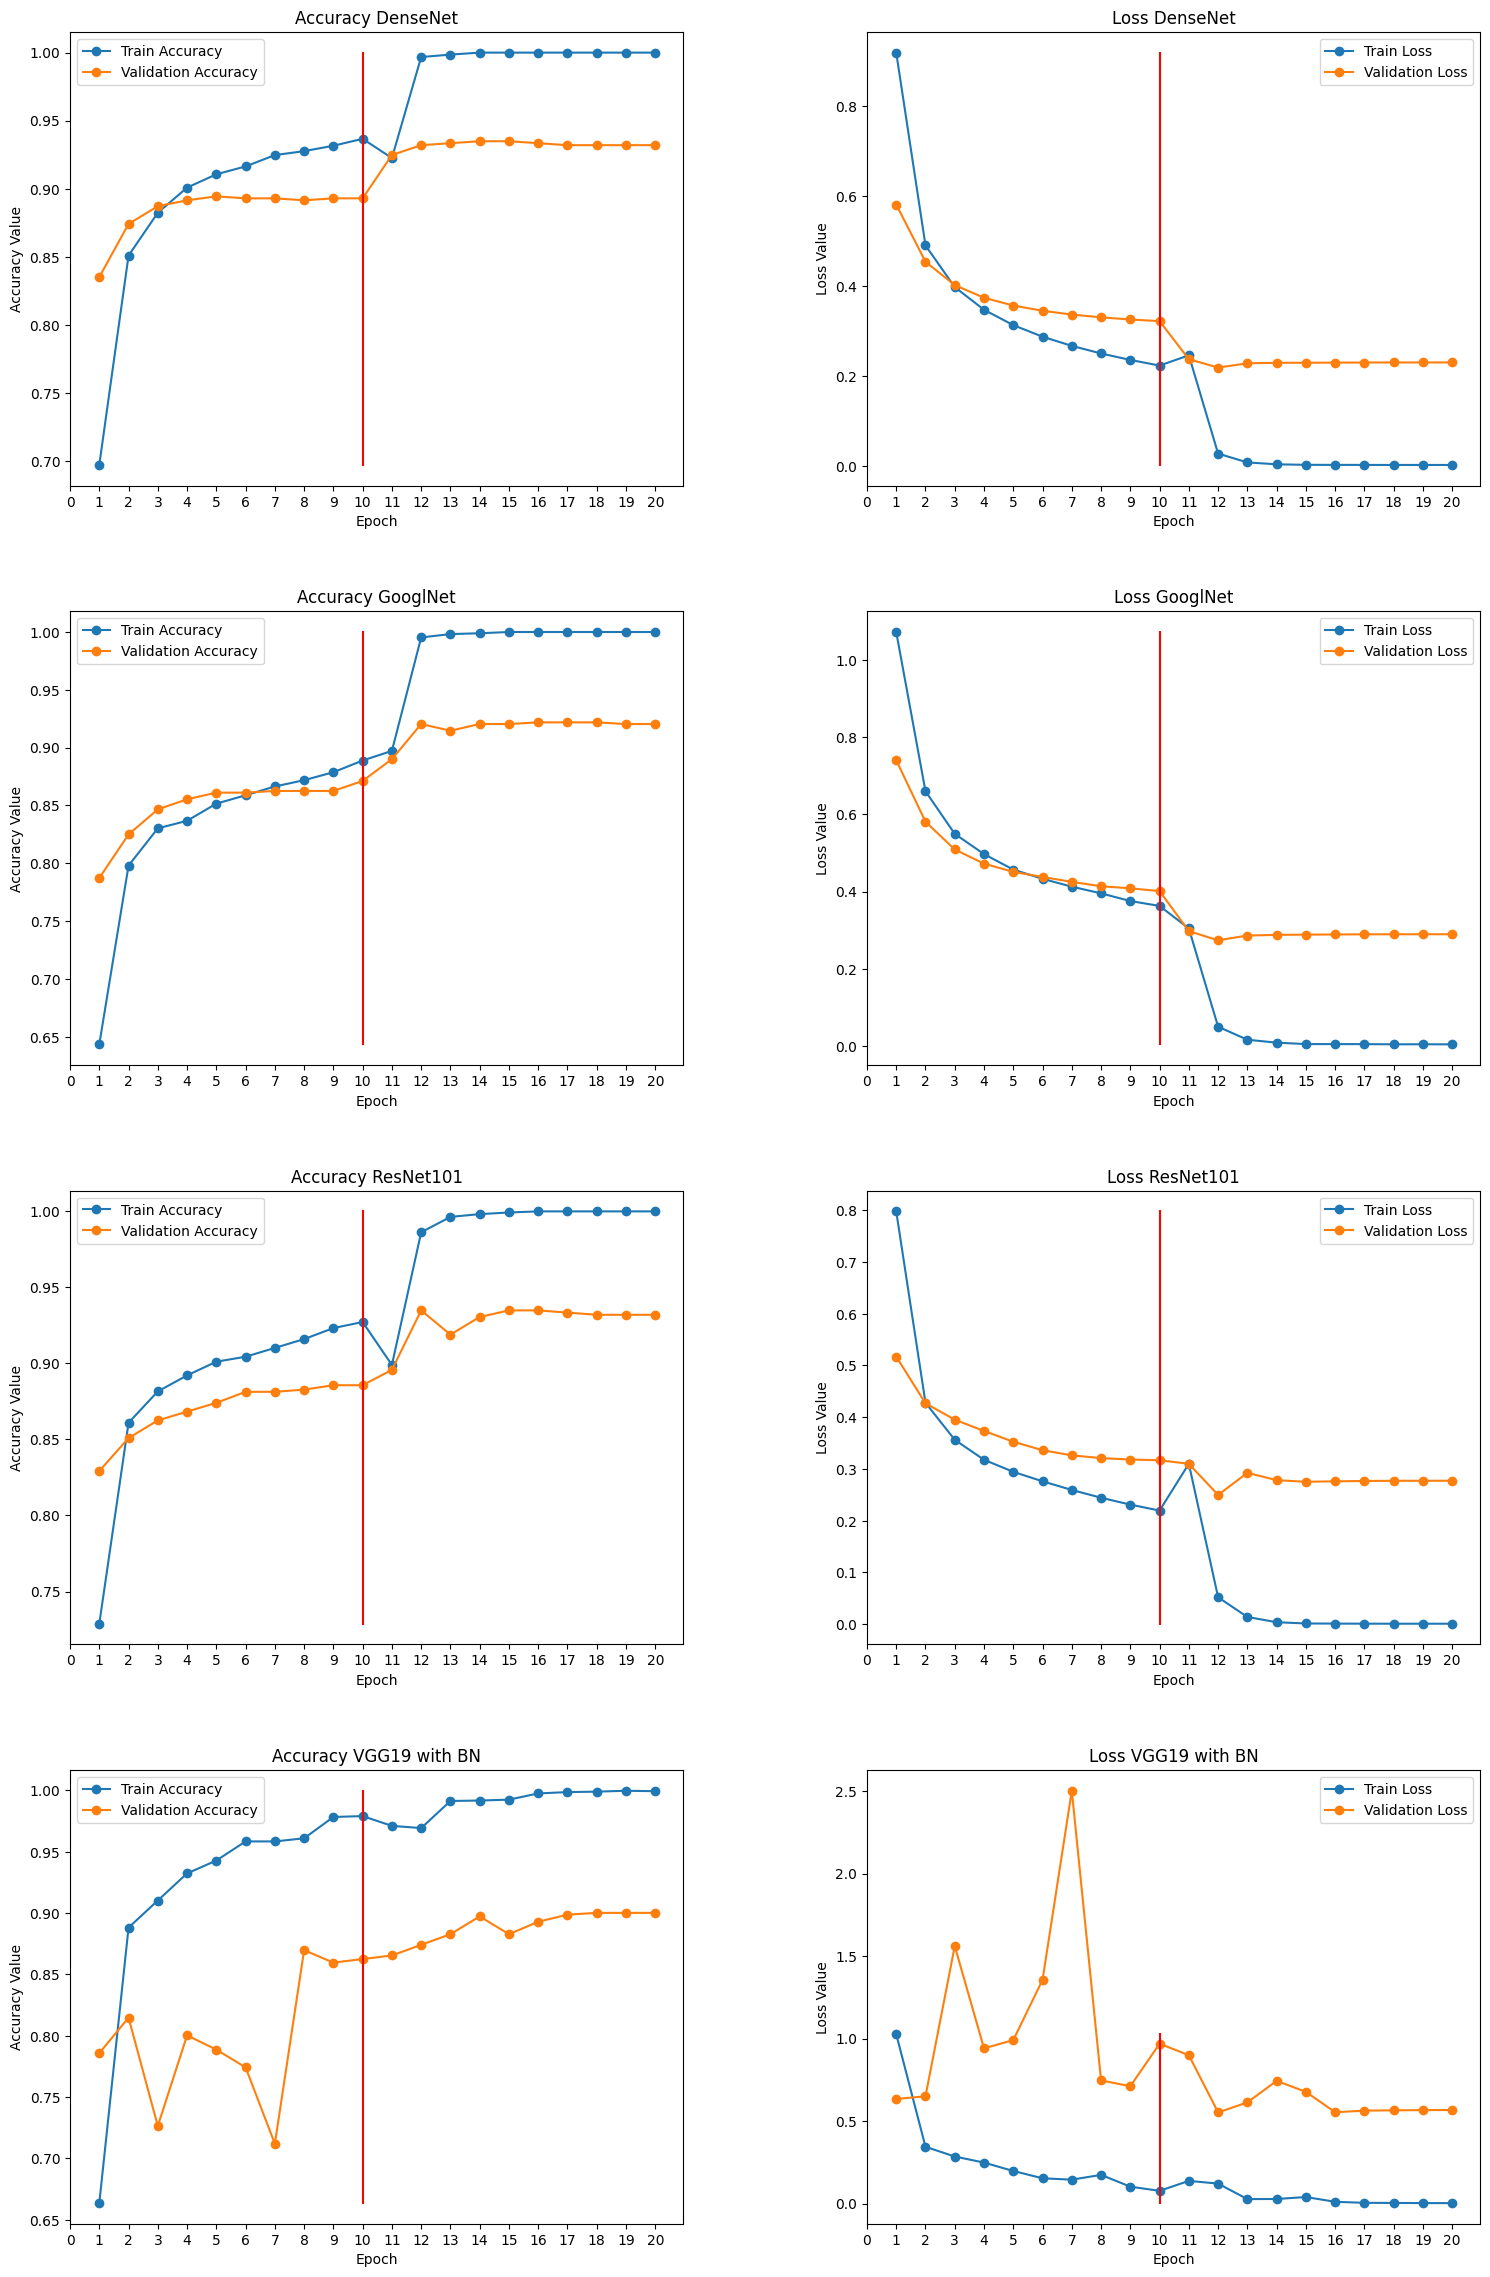

In [ ]:
fig, ax = plt.subplots(4, 2, figsize=(15, 15))
modelname = ['DenseNet','GooglNet', 'ResNet101', 'VGG19 with BN']

i=0

for row in range(4):

  epoch_list = list(range(1,epochs*2+1))

  ax[row][0].plot(epoch_list, torch.tensor(accuracies['train'][i:20+i]), '-o', label='Train Accuracy')
  ax[row][0].plot(epoch_list, torch.tensor(accuracies['val'][i:20+i]), '-o', label='Validation Accuracy')
  ax[row][0].plot([epochs for x in range(20)],  np.linspace(min(accuracies['train'][i:20+i]).cpu(), max(accuracies['train'][i:20+i]).cpu(), 20), color='r')
  ax[row][0].set_xticks(np.arange(0, epochs*2+1, 1))
  ax[row][0].set_ylabel('Accuracy Value')
  ax[row][0].set_xlabel('Epoch')
  ax[row][0].set_title('Accuracy {}'.format(modelname[row]))
  ax[row][0].legend(loc="best")

  ax[row][1].plot(epoch_list, losses['train'][i:20+i], '-o', label='Train Loss')
  ax[row][1].plot(epoch_list, losses['val'][i:20+i], '-o',label='Validation Loss')
  ax[row][1].plot([epochs for x in range(20)], np.linspace(min(losses['train'][i:20+i]), max(losses['train'][i:20+i]), 20), color='r')
  ax[row][1].set_xticks(np.arange(0, epochs*2+1, 1))
  ax[row][1].set_ylabel('Loss Value')
  ax[row][1].set_xlabel('Epoch')
  ax[row][1].set_title('Loss {}'.format(modelname[row]))
  ax[row][1].legend(loc="best")
  fig.tight_layout()
  fig.subplots_adjust(top=1.5, wspace=0.3)

  i+=20

- Ở cả bốn mô hình đều cho chỉ số accuracy cao nhất ở tập train nằm trong khoảng 0.9 đến 0.95 trong 10 epoch đầu. Accuracy cao nhất của tập val nằm trong khoảng 0.85 đến 0.9.
- Trong 10 epoch đầu thì:
- Ở mô hình googlnet thì chỉ số accuracy của tập train và chỉ số accuracy tập val chênh lệch ít nhất.
- Ở mô hình densenet và resnet101 thì chỉ số accuracy của tập train và chỉ số accuracy tập val chênh lệch nhau nhiều hơn so với mô hình googlnet nhưng ít hơn so với mô hình vgg19.
- Mô hình vgg19 có chỉ số accuracy của tập train và tập test chênh lệch nhau nhiều nhất. Cụ thể là chỉ số accuracy tập train lớn hơn, cách xa hơn so với chỉ số accuracy ở tập val nếu so sánh với 3 mô hình còn lại, chỉ số loss value cũng vậy.***-> Điều này cho thấy với bộ dữ liệu trên thì trong số 4 mô hình thì mô hình vgg19 đã gặp phải hiện tượng overfitting.***

- Trong 10 epoch sau:
- Sau 10 epoch đầu tiên, sau khi tìm ra tham số tốt nhất thì ở 10 epoch tiếp theo, chỉ số accuracy của tập train và tập val được cải thiện hơn, tương tự như vậy, chỉ số lỗi cũng giảm đi đáng kể.
- Từ epoch 13 đến epoch 20 đối với mô hình densenet và googlnet, epoch 15 đến epoch 20 đối với mô hình resne101 và vgg19 thì độ chênh lệch giữa chỉ số accuracy cùng như chỉ số loss value của tập train và tập val dao động trong một khoảng nhất định, không thay đổi.
- Từ epoch 11 đến epoch 20, ở các mô hình, tuy chỉ số accuracy tăng lên và chỉ số lỗi giảm xuống nhưng sự chênh lệch của hai chỉ số này giữa tập train và tập val lại cao hơn so với 10 epoch đầu. Trong đó, chênh lệch lớn nhất giữa chỉ số accuracy giữa tập train và tập val xấp xỉ 0.15. Trong trường hợp này thì đây là một con số không quá lớn, có thể chấp nhận được.
- Đối với mô hình vgg19 từ epoch 11 đến epoch 20 mặc dù sự chênh lệch các chỉ số accuracy và loss valua vẫn lớn hơn so 4 mô hình còn lại nhưng đã được giảm xuống khá nhiều so với 10 epoch đầu. Chênh lệch lớn nhất giữa chỉ số accuracy giữa tập train và tập val là 0.15. Ở chỉ số loss value ở epoch 11 thì sự chênh lệch xấp xỉ 0.9, tuy nhiên, ở những epoch cuối, chênh lệch giảm xuống ở mức 0.6 và không thay đổi.***-> Tình trạng overfitting của vgg19 được cải thiện khi chỉ số accuracy ở tập train không còn quá cao so với chỉ số accuracy của tập val, tương tự như vậy, chỉ số loss value của tập train cũng không quá thấp so với chỉ số loss value ở tập val.***

### 4. Dự đoán trên tập test

In [ ]:
class Ensemble(nn.Module):
    def __init__(self, device):
        super(Ensemble,self).__init__()
        self.models = nn.ModuleList(models)

    def forward(self, x):
        output = torch.zeros([x.size(0), len(original.classes)]).to(device) # Khởi tạo Tensor Đầu Ra
        for model in self.models:# lặp qua các mô hình
            output += model(x)
        return output# Trả về tensor output chứa tổng hợp của tất cả các dự đoán từ các mô hình trong ensemble

In [ ]:
model =  Ensemble(device)

 - Dùng phương pháp ensemble tổng hợp các dự đoán của tất cả 4 mô hình trên. Trong đó các dự đoán của từng mô hình được cộng lại.

In [ ]:
def validation_step(batch):
        images,labels = batch
        images,labels = images.to(device),labels.to(device)
        out = model(images) # Dự đoán
        loss = F.cross_entropy(out, labels)
        acc,preds = accuracy(out, labels)

        return {'val_loss': loss.detach(), 'val_acc':acc.detach(),
                'preds':preds.detach(), 'labels':labels.detach()}

In [ ]:
def test_prediction(outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        # kết hợp dự đoán
        batch_preds = [pred for x in outputs for pred in x['preds'].tolist()]
        # Kết hợp nhãn
        batch_labels = [lab for x in outputs for lab in x['labels'].tolist()]

        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item(),
                'test_preds': batch_preds, 'test_labels': batch_labels}

In [ ]:
@torch.no_grad()
def test_predict(model, test_loader):
    model.eval()
    # kiểm tra từng batch
    outputs = [validation_step(batch) for batch in test_loader]
    results = test_prediction(outputs)
    print('test_loss: {:.4f}, test_acc: {:.4f}'
          .format(results['test_loss'], results['test_acc']))

    return results['test_preds'], results['test_labels']

In [ ]:
model.to(device)
preds,labels = test_predict(model, loaders['test'])

test_loss: 0.5630, test_acc: 0.9416


Chỉ số accuracy là 0.94 và chỉ số lỗi là 0.536. Đây là điều khá khả quan

In [ ]:
def norm_out(img):

    img = img.permute(1,2,0)
    mean = torch.FloatTensor([0.4124234616756439, 0.3674212694168091, 0.2578217089176178])
    std = torch.FloatTensor([0.3268945515155792, 0.29282665252685547, 0.29053378105163574])

    img = img*std + mean

    return np.clip(img,0,1)

### 5. Kiểm tra kết quả

####5.1 Dự đoán ngẫu nhiên

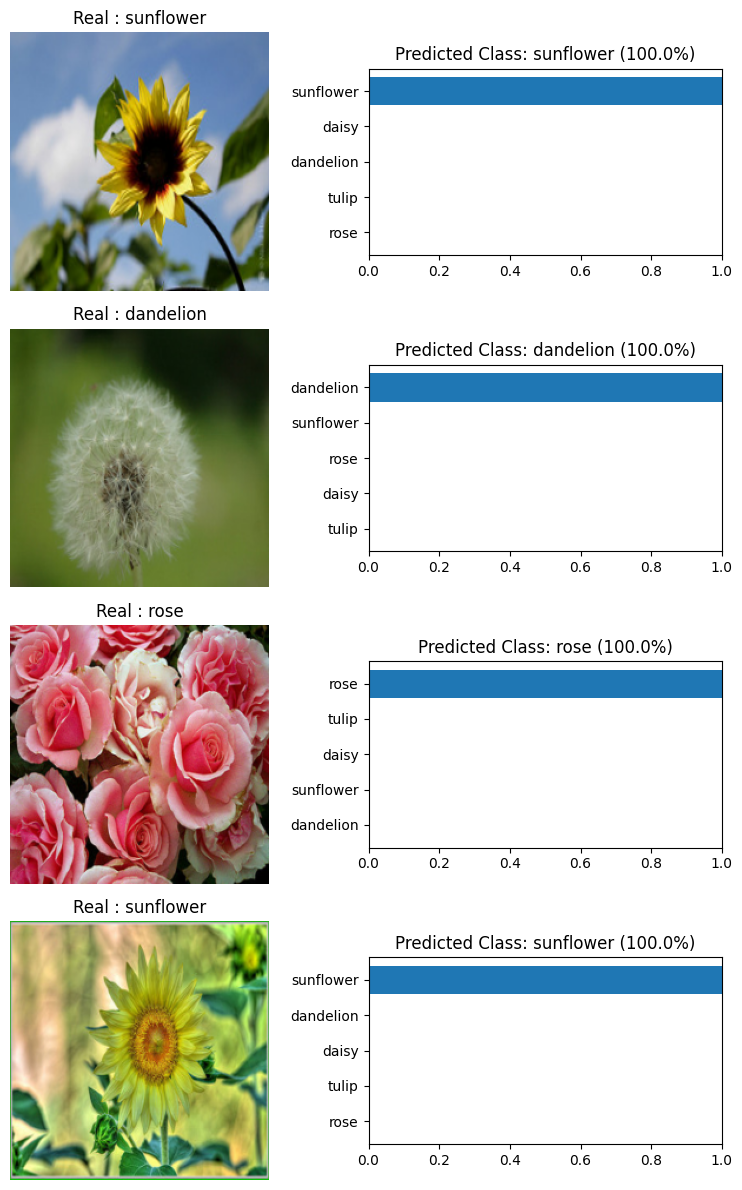

In [ ]:
fig, ax = plt.subplots(figsize=(8,12), ncols=2, nrows=4)

for row in range(4):
    i = np.random.randint(0, high=len(test))
    img,label = test[i]

    m = nn.Softmax(dim=1)
    percent = m(model(img.to(device).unsqueeze(0)))
    predmax3percent = torch.sort(percent[0])[0]
    predmax3inds = torch.sort(percent[0])[1]
    classes = np.array([original.classes[predmax3inds[-5]], original.classes[predmax3inds[-4]], original.classes[predmax3inds[-3]], original.classes[predmax3inds[-2]],original.classes[predmax3inds[-1]]])
    class_name = original.classes

    ax[row][0].imshow(norm_out(img))
    ax[row][0].set_title('Real : {}'.format(class_name[label]))
    ax[row][0].axis('off')
    ax[row][1].barh(classes, predmax3percent.detach().cpu().numpy())
    ax[row][1].set_aspect(0.1)
    ax[row][1].set_yticks(classes)
    ax[row][1].set_title('Predicted Class: {} ({}%)'.format(original.classes[predmax3inds[-1]], round((predmax3percent[-1]*100).item(), 2)))
    ax[row][1].set_xlim(0, 1.)
    plt.tight_layout()

###5.2 Đánh giá kết quả dự đoán

In [ ]:
report = classification_report(labels, preds,
                               output_dict=True,
                               target_names=original.classes)
report_df = pd.DataFrame(report).transpose()

In [ ]:
pd.set_option("display.max_rows", None)
report_df.head(5)

,precision,recall,f1-score,support
daisy,0.969231,0.919708,0.943820,137.0
dandelion,0.952790,0.982301,0.967320,226.0
rose,0.853503,0.937063,0.893333,143.0
sunflower,0.965517,0.952381,0.958904,147.0
tulip,0.964824,0.909953,0.936585,211.0


In [ ]:
print(report_df.iloc[5:8])

              precision    recall  f1-score    support
accuracy       0.942130  0.942130  0.942130    0.94213
macro avg      0.941173  0.940281  0.939993  864.00000
weighted avg   0.944068  0.942130  0.942411  864.00000


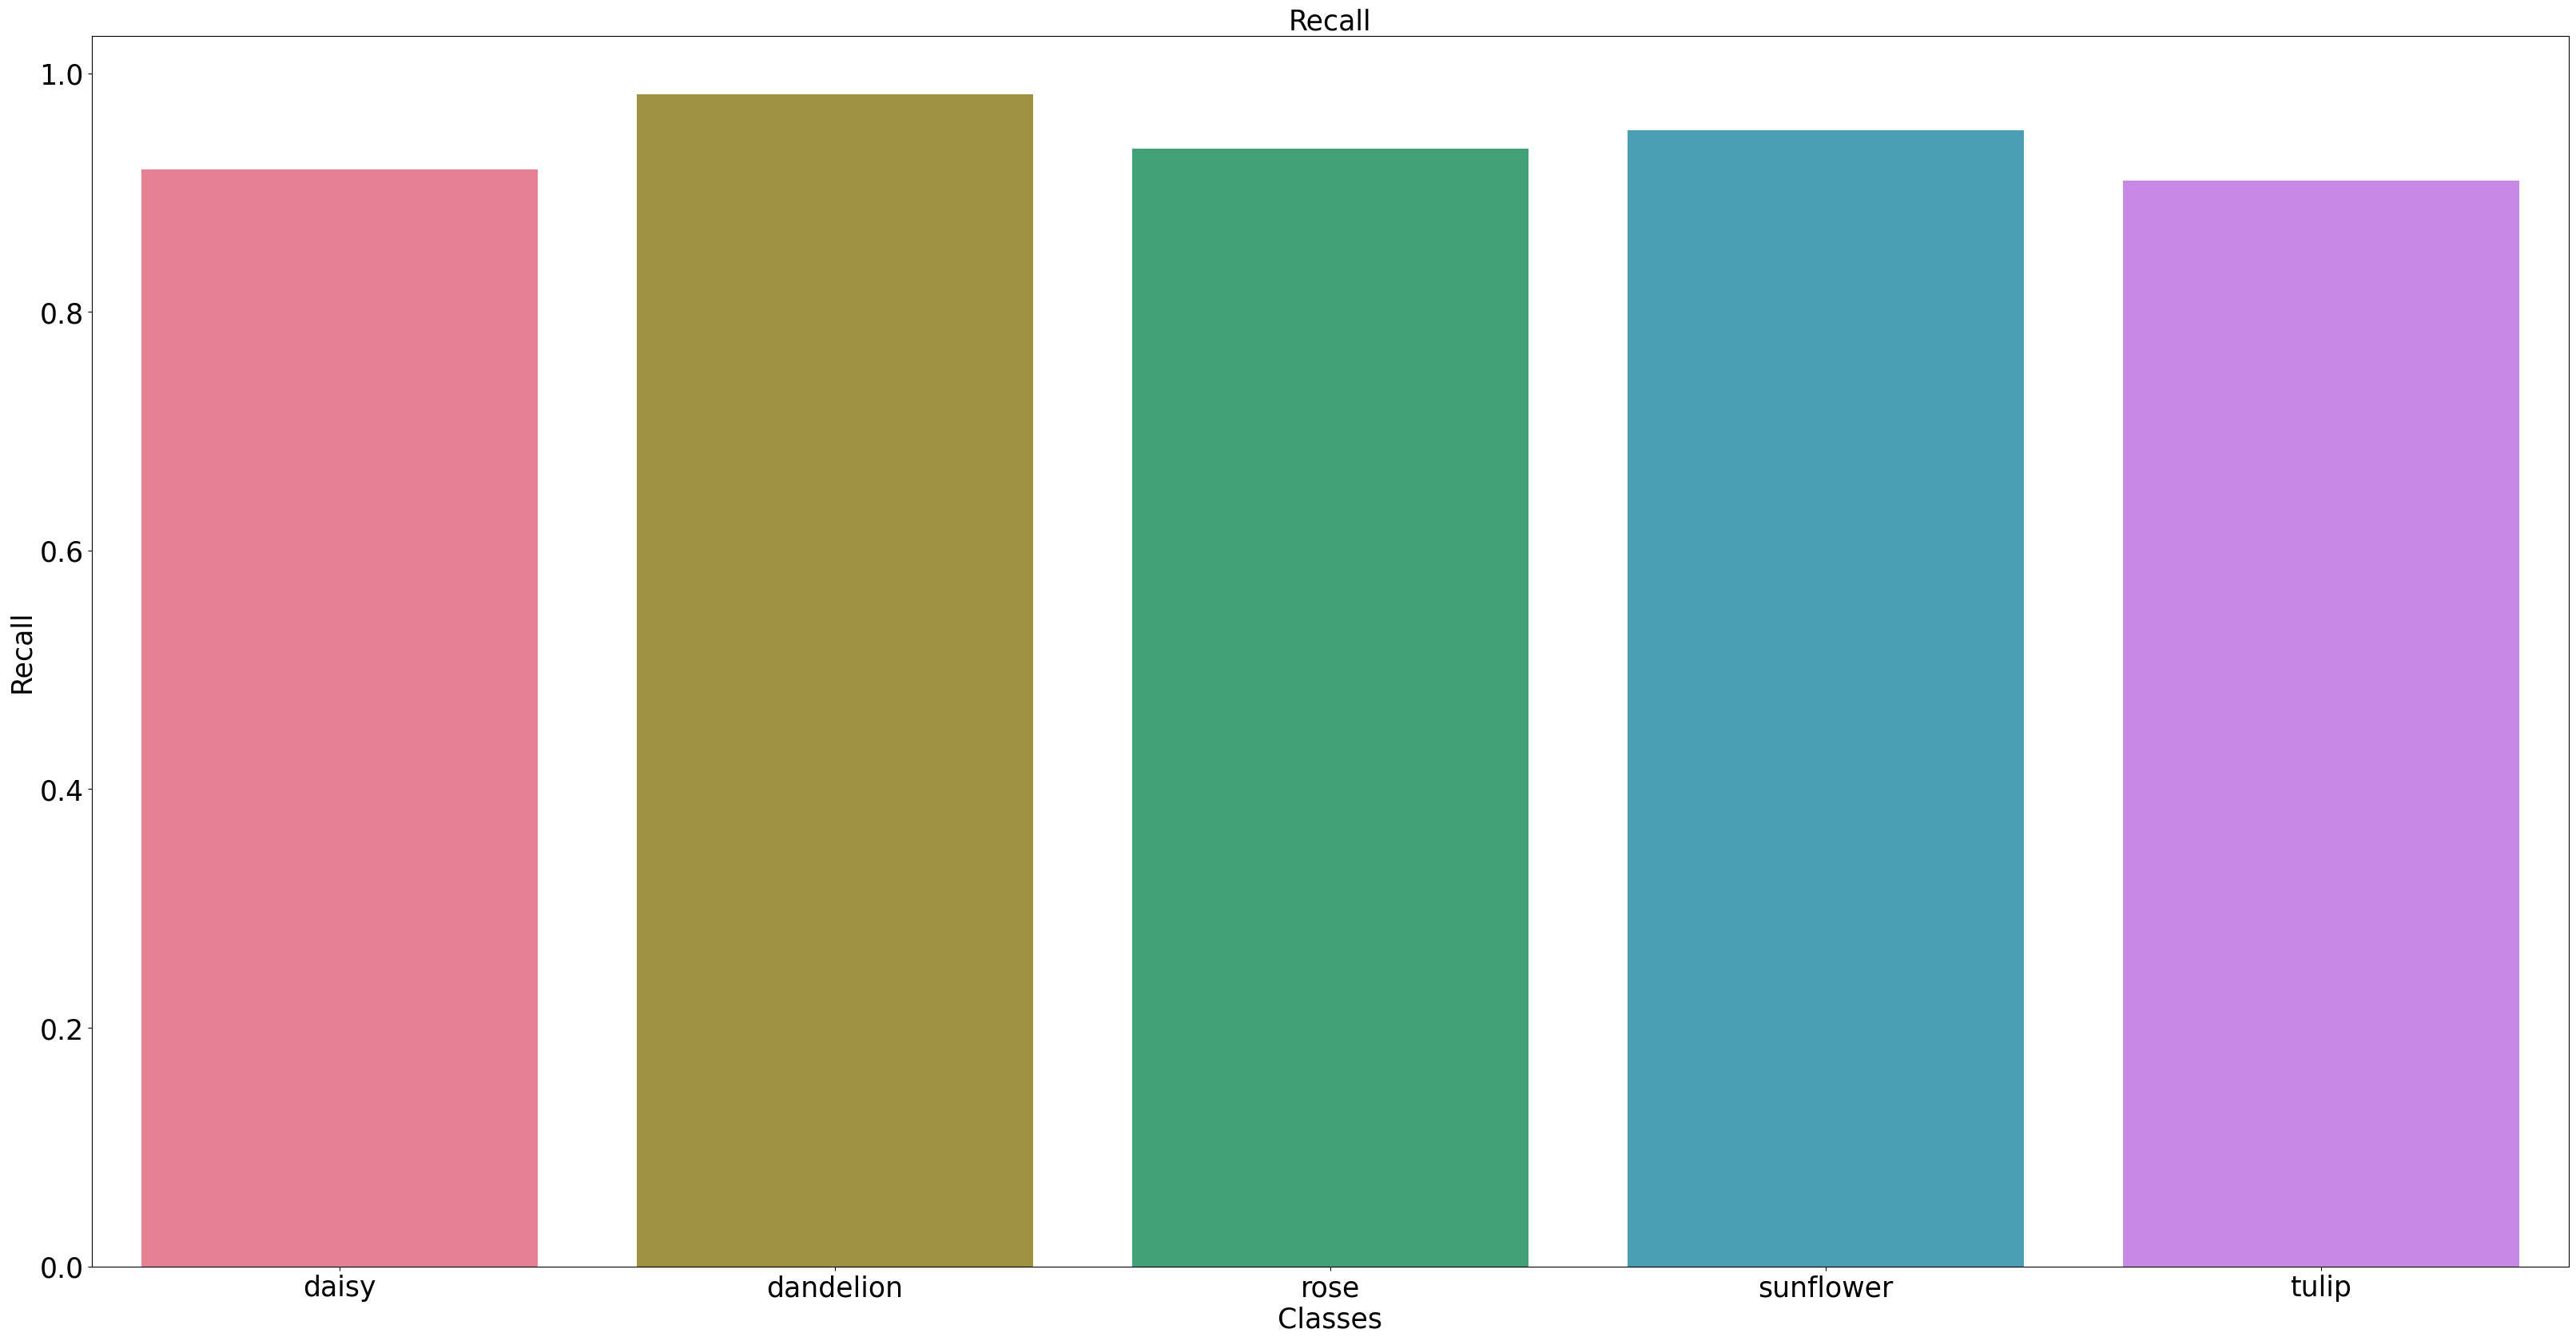

In [ ]:
data_to_plot = report_df.iloc[:5, 1].copy()
class_names = data_to_plot.index
ax = sns.barplot(x=class_names, y=data_to_plot, ci=None, palette="husl")
ax.set_xlabel('Classes', fontsize=25)
ax.set_ylabel('Recall', fontsize=25)
ax.set_title('Recall', fontsize=25)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=25)
ax.tick_params(axis='y', labelsize=25)

plt.show()


- Lớp dandelion có chỉ số recall cao nhất.
- Lớp sunflower có chỉ số recall xếp thứ hai.
- Lớp rose có chỉ số recall xếp thứ ba.
- Lớp daisy có chỉ số recall xếp thứ tư.
- Lớp tulip có chỉ số recall thấp nhất trong năm lớp.

<Figure size 4000x2000 with 0 Axes>

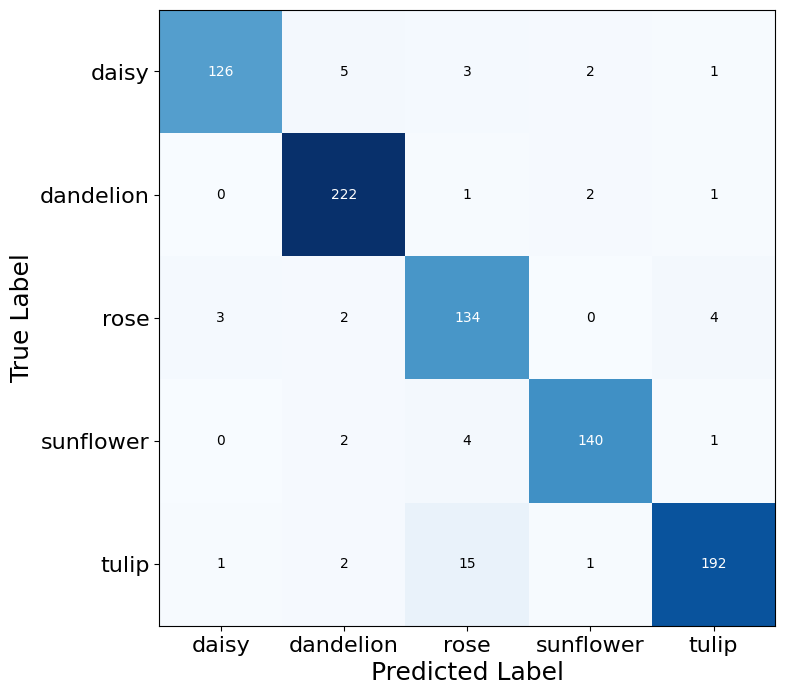

In [ ]:
cm  = confusion_matrix(labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8),cmap=plt.cm.Blues)
plt.xticks(range(len(original.classes)), original.classes, fontsize=16)
plt.yticks(range(len(original.classes)), original.classes, fontsize=16)
plt.xlabel('Predicted Label',fontsize=18)
plt.ylabel('True Label',fontsize=18)
plt.show()

- Lớp dandelion nhận dạng đúng 222/226 mẫu.
- Lớp sunflower nhận dạng đúng 140/147 mẫu.
- Lớp rose nhận dạng đúng 134/143 mẫu.
- Lớp daisy nhận dạng đúng 126/137 mẫu.
- Lớp tulip nhận dạng đúng 192/211 mẫu